### Open AI Gym

Reinforcement Learning with CartePole

In [1]:
# Common imports
import numpy as np
import os
import sys
import gym
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import time
from tqdm import tqdm_notebook

%matplotlib nbagg

In [2]:
# Utility function that hides a lot of the heavy lifting
from render_utils import *
from reward_functions import *

%load_ext autoreload
%autoreload 2

In [49]:
# ---------- Initialise CartePole -------------
env = gym.make('CartPole-v0')
obs = env.reset()
obs

array([-0.02226242,  0.03359643, -0.02147887, -0.028351  ])

* `obs` is the new observation 
        [position of cart, velocity of cart, angle of pole, rotation rate of pole]
* `reward` is given 1 point at every step, the goal is to keep running as long as possible
* `done` This value will be true when the episode is over
* `info` This dictionary may provide extra debug information in other environments

The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [50]:
# Helper functions

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### Reinforcement Learning - Policy Gradients
* The Policy Gradients algorithm tackles the problem by playing multiple games

In [212]:
# ------- Build Tensorflow Graph -------

import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 8
n_outputs = 1

learning_rate = 0.01

initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # probability of action 0 (left)
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

# --------------------------------------

In [213]:
def render_policy_net(model_path, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    action_val = 0
    
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            # Send step to rendering function
            img = render_cart_pole(env, obs, step, action_val)
            frames.append(img)
            
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            
            if done:
                break
    env.close()
    return frames

In [ ]:
# ------- Run Session -------

env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in tqdm_notebook(range(n_iterations)):
        print("\rIteration: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        all_obs = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            current_obs = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                current_obs.append(obs)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
            all_obs.append(current_obs)

        all_rewards = discount_and_normalize_rewards(all_rewards, all_obs, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./model/policy-grad-drift-penalty.ckpt")
            print(' ', len(current_rewards))

Iteration: 0  31
Iteration: 10  62
Iteration: 20  42
Iteration: 30  72
Iteration: 34
Iteration: 40  31
Iteration: 50  46
Iteration: 60  62
Iteration: 70  99
Iteration: 80  92
Iteration: 90  109
Iteration: 100  200
Iteration: 110  102
Iteration: 120  83
Iteration: 130  63
Iteration: 140  69
Iteration: 150  69
Iteration: 160  101
Iteration: 170  92
Iteration: 180  86
Iteration: 190  116
Iteration: 200  154
Iteration: 210  77
Iteration: 220  65
Iteration: 230  53
Iteration: 240  85
Iteration: 250  69
Iteration: 260  110
Iteration: 270  76
Iteration: 280  103
Iteration: 289

In [215]:
env.close()

INFO:tensorflow:Restoring parameters from ./model/policy-grad-drift-penalty.ckpt


<IPython.core.display.Javascript object>


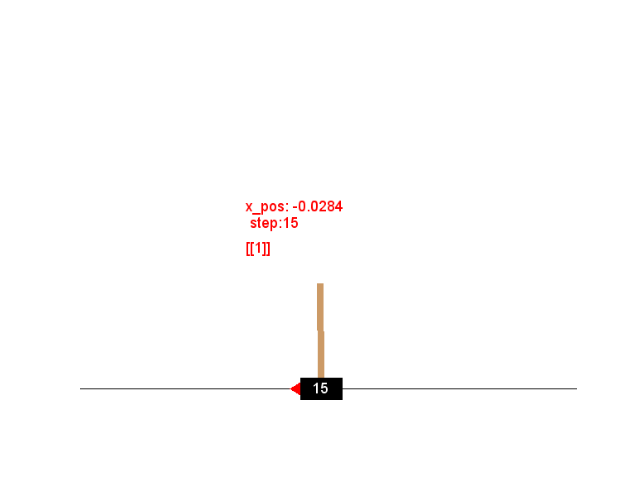

In [239]:
frames = render_policy_net("./model/policy-grad-drift-penalty.ckpt", X, n_max_steps=2000)
video = plot_animation(frames, repeat=True)
plt.show()

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg_epoch.ckpt


<IPython.core.display.Javascript object>


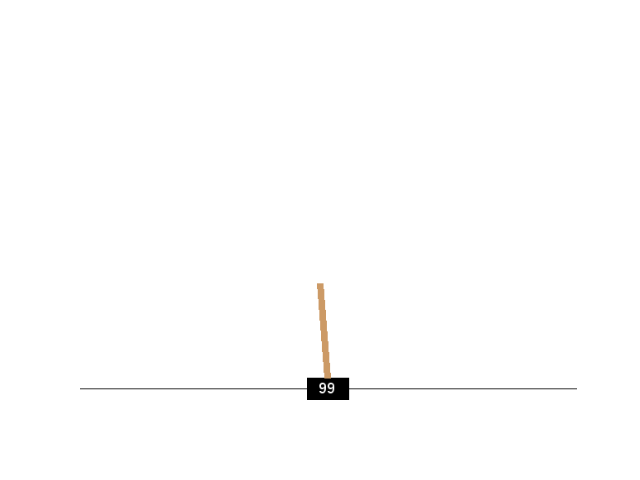

In [137]:
# long epoch render
frames = render_policy_net("./my_policy_net_pg_epoch.ckpt", X, n_max_steps=2000)
video = plot_animation(frames, repeat=True)
plt.show()